## **Importing Necessary Libraries**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import pandas as pd
from skimage.filters import prewitt_h,prewitt_v
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
import sklearn.neural_network as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## **Connect to the colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Classification Models on our own extraction features*

## **Functions**

In [ ]:
size_image = 100

In [ ]:
from_source = ['stable', 'dalle', 'dreamstudio', 'midjourney',
               'dream', 'bing', 'craiyon', 'none']
from_class = {'mountain': 0, 'sea': 1, 'jungle': 2}
def get_feature_from_path(path):

  splited_path = (path.replace("delle", "dalle").replace("dreamai", "dream")
      .replace("-", "_").replace("sea5", "sea_5").replace("dallebot", "dalle")
      .replace(".", "").replace("forest", "jungle").replace("see", "sea")
      .replace("dall", "dalle").replace("dallee", "dalle")
      .replace("dalleminibot", "dalle").replace("dallemini", "dalle")
      .replace("dalleminbot", "dalle") .replace("junlge", "jungle")
      .lower().split("_"))

  if (len(splited_path) != 5):
    print(splited_path)
  source = splited_path[2]
  image_class = splited_path[3]
  if source not in from_source:
    print(source, path)

  if image_class not in from_class:
    print(image_class, path)

  return source, from_class[image_class]

In [ ]:
def get_average_of_pixels(image):
  feature_matrix = np.zeros((size_image, size_image))
  for i in range(0,image.shape[0]):
    for j in range(0,image.shape[1]):
        feature_matrix[i][j] = ((int(image[i,j,0]) + int(image[i,j,1]) + int(image[i,j,2]))/3)
  return np.reshape(feature_matrix, size_image*size_image)

In [ ]:
def get_edge_of_image(image):
  edges = cv2.Canny(image, 50, 150)
  return np.reshape(edges, size_image*size_image)

In [ ]:
def get_color_histogram(image, bins=8):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [bins], [0, 180])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])
    hist_features = np.concatenate((hist_hue, hist_saturation, hist_value)).flatten()
    hist_features /= hist_features.sum()
    return hist_features

In [ ]:
def get_features(image):
  source, image_class_index = get_feature_from_path(filename)
  aop = get_average_of_pixels(img_arr)
  gray_img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
  eoi = get_edge_of_image(gray_img_arr)
  ch = get_color_histogram(img_arr)
  features_of_image = np.array(aop)
  features_of_image = np.append(features_of_image, eoi, axis=0)
  features_of_image = np.append(features_of_image, ch, axis=0)
  return np.append(features_of_image, np.array([image_class_index]), axis=0)

### **fake data**

In [ ]:
dir_path = '/content/drive/MyDrive/ML/Copy of fake'

features_of_images = list()
labels = list()

for filename in os.listdir(dir_path):
    if (filename.endswith("jpeg") or filename.endswith(".jpg") or
        filename.endswith(".png") or filename.endswith(".jfif")):
        img = cv2.imread(os.path.join(dir_path, filename))
        img = cv2.resize(img, (size_image, size_image))
        img_arr = np.array(img)
        features_of_images.append(get_features(img))
        labels.append(0)
        for i in range(3):
          img_arr = cv2.rotate(img_arr, cv2.ROTATE_90_CLOCKWISE)
          features_of_images.append(get_features(img))
          labels.append(0)
        img_arr = cv2.rotate(img_arr, cv2.ROTATE_90_CLOCKWISE)
        for i in range(2):
          img_arr = cv2.flip(img_arr, i)
          features_of_images.append(get_features(img))
          labels.append(0)
    else:
      print(filename)

### **real data**

In [ ]:
dir_path = '/content/drive/MyDrive/ML/Copy of real'

for filename in os.listdir(dir_path):
    if (filename.endswith("jpeg") or filename.endswith(".jpg") or
        filename.endswith(".png") or filename.endswith(".jfif")):
        try:
          img = cv2.imread(os.path.join(dir_path, filename))
          img = cv2.resize(img, (size_image, size_image))
          img_arr = np.array(img)
          features_of_images.append(get_features(img))
          labels.append(1)
          for i in range(3):
            img_arr = cv2.rotate(img_arr, cv2.ROTATE_90_CLOCKWISE)
            features_of_images.append(get_features(img))
            labels.append(1)
          img_arr = cv2.rotate(img_arr, cv2.ROTATE_90_CLOCKWISE)
          for i in range(2):
            img_arr = cv2.flip(img_arr, i)
            features_of_images.append(get_features(img))
            labels.append(1)
        except Exception as e:
          print(e, filename)
    else:
      print(filename)

## **Split and normalize data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## **SVM 128*128 data low**

accrracy of SVM is 67.02
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1030
           1       0.68      0.65      0.66      1020

    accuracy                           0.67      2050
   macro avg       0.67      0.67      0.67      2050
weighted avg       0.67      0.67      0.67      2050



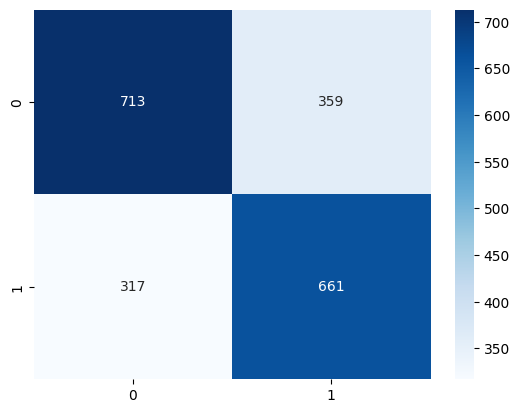

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **SVM with PCA 128*128 data low**

accrracy of SVM is 67.66
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1030
           1       0.69      0.63      0.66      1020

    accuracy                           0.68      2050
   macro avg       0.68      0.68      0.68      2050
weighted avg       0.68      0.68      0.68      2050



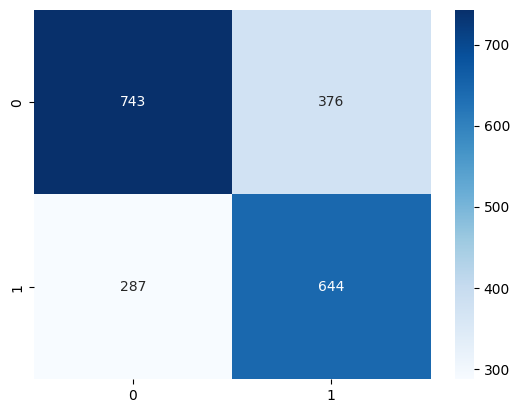

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **SVM 100*100 With a lot of data**

accrracy of SVM is 75.85
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2055
           1       0.77      0.74      0.75      2045

    accuracy                           0.76      4100
   macro avg       0.76      0.76      0.76      4100
weighted avg       0.76      0.76      0.76      4100



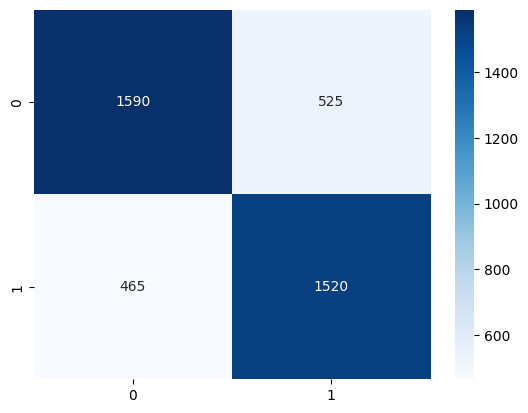

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **SVM with PCA 100*100 With a lot of data**

accrracy of SVM is 70.54
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      2055
           1       0.72      0.67      0.69      2045

    accuracy                           0.71      4100
   macro avg       0.71      0.71      0.71      4100
weighted avg       0.71      0.71      0.71      4100



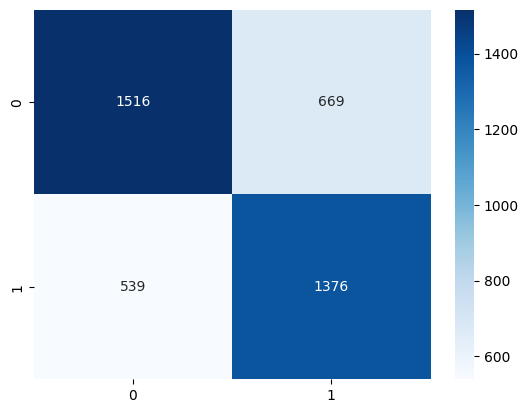

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

accrracy of SVM is 72.90
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      2055
           1       0.75      0.69      0.72      2045

    accuracy                           0.73      4100
   macro avg       0.73      0.73      0.73      4100
weighted avg       0.73      0.73      0.73      4100



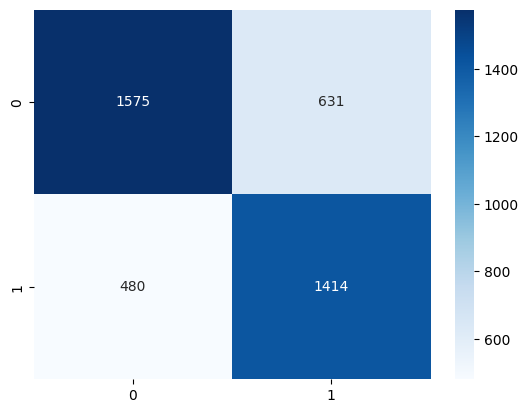

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

pca = PCA(n_components = 500)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **LogisticRegression 128*128 data low**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accrracy of logistic_regression is 60.39
              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1030
           1       0.60      0.60      0.60      1020

    accuracy                           0.60      2050
   macro avg       0.60      0.60      0.60      2050
weighted avg       0.60      0.60      0.60      2050



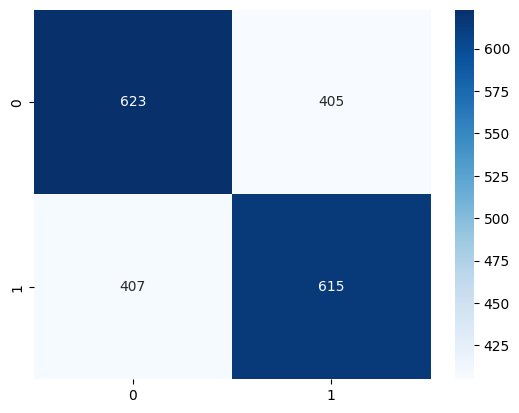

In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **LogisticRegression with PCA 128*128 data low**

accrracy of logistic_regression is 59.02
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      1030
           1       0.59      0.60      0.59      1020

    accuracy                           0.59      2050
   macro avg       0.59      0.59      0.59      2050
weighted avg       0.59      0.59      0.59      2050



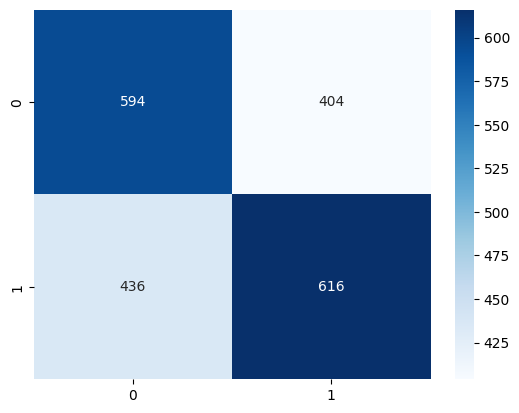

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **LogisticRegression 100*100 With a lot of data**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accrracy of logistic_regression is 67.00
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      2055
           1       0.64      0.76      0.70      2045

    accuracy                           0.67      4100
   macro avg       0.68      0.67      0.67      4100
weighted avg       0.68      0.67      0.67      4100



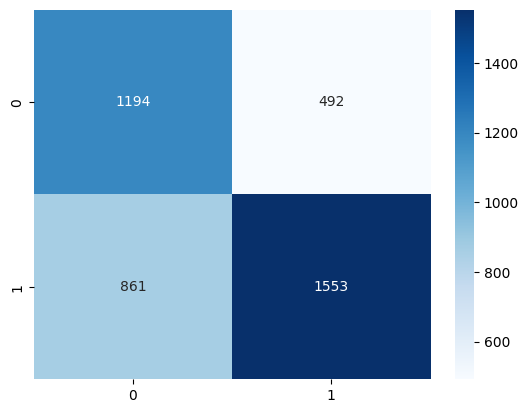

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **LogisticRegression with PCA 100*100 With a lot of data**

accrracy of logistic_regression is 57.93
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2055
           1       0.58      0.60      0.59      2045

    accuracy                           0.58      4100
   macro avg       0.58      0.58      0.58      4100
weighted avg       0.58      0.58      0.58      4100



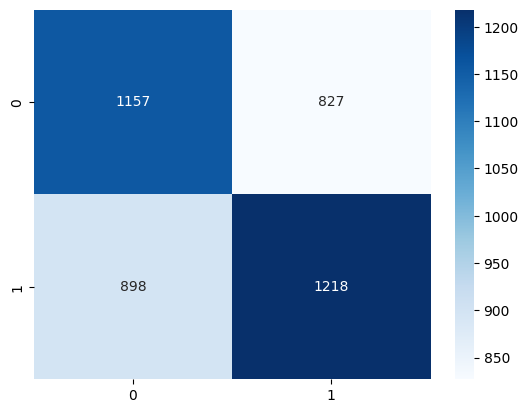

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **GaussianNB 128*128 data low**

accrracy of Gaussian is 54.63
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      1030
           1       0.55      0.49      0.52      1020

    accuracy                           0.55      2050
   macro avg       0.55      0.55      0.54      2050
weighted avg       0.55      0.55      0.54      2050



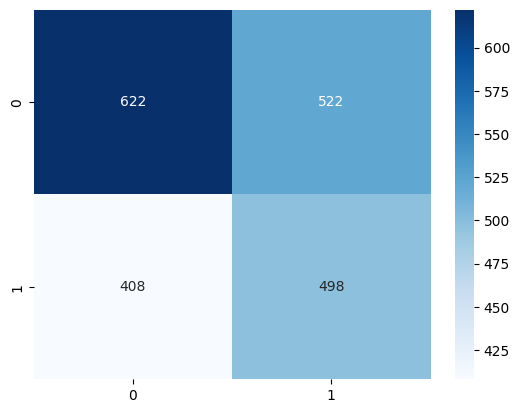

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **GaussianNB with PCA 128*128 data low**

accrracy of Gaussian is 61.27
              precision    recall  f1-score   support

           0       0.65      0.50      0.57      1030
           1       0.59      0.72      0.65      1020

    accuracy                           0.61      2050
   macro avg       0.62      0.61      0.61      2050
weighted avg       0.62      0.61      0.61      2050



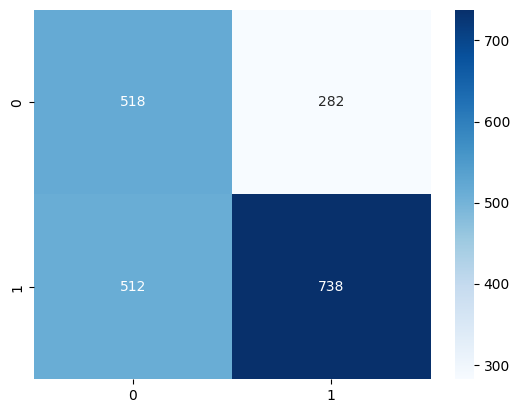

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **GaussianNB 100*100 With a lot of data**

accrracy of Gaussian is 53.88
              precision    recall  f1-score   support

           0       0.53      0.62      0.58      2055
           1       0.55      0.45      0.49      2045

    accuracy                           0.54      4100
   macro avg       0.54      0.54      0.54      4100
weighted avg       0.54      0.54      0.54      4100



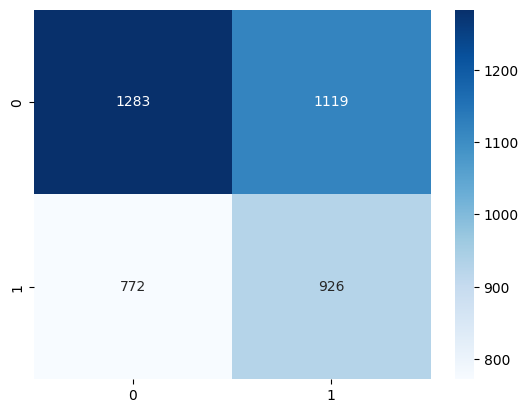

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **GaussianNB with PCA 100*100 With a lot of data**

accrracy of Gaussian is 59.37
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      2055
           1       0.58      0.69      0.63      2045

    accuracy                           0.59      4100
   macro avg       0.60      0.59      0.59      4100
weighted avg       0.60      0.59      0.59      4100



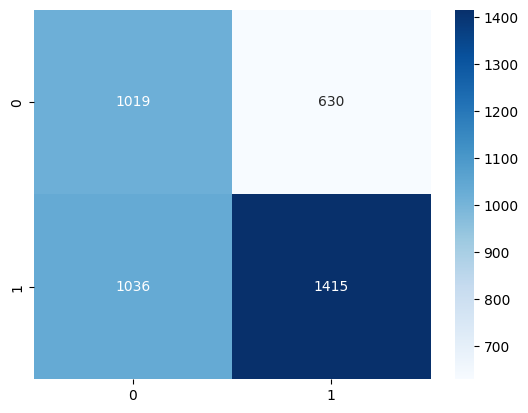

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **MLP 128*128 data low**

accrracy of Gaussian is 62.88
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      1030
           1       0.63      0.61      0.62      1020

    accuracy                           0.63      2050
   macro avg       0.63      0.63      0.63      2050
weighted avg       0.63      0.63      0.63      2050



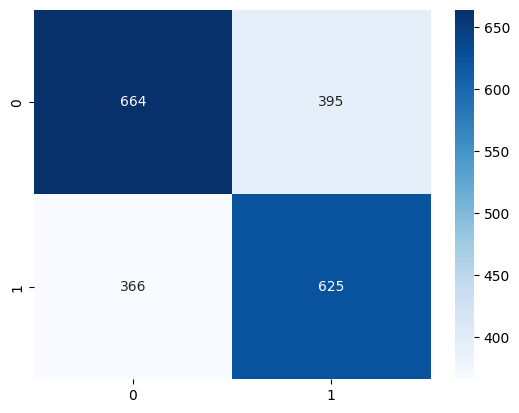

In [ ]:
mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **MLP with PCA 128*128 data low**

accrracy of Gaussian is 63.66
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1030
           1       0.64      0.62      0.63      1020

    accuracy                           0.64      2050
   macro avg       0.64      0.64      0.64      2050
weighted avg       0.64      0.64      0.64      2050



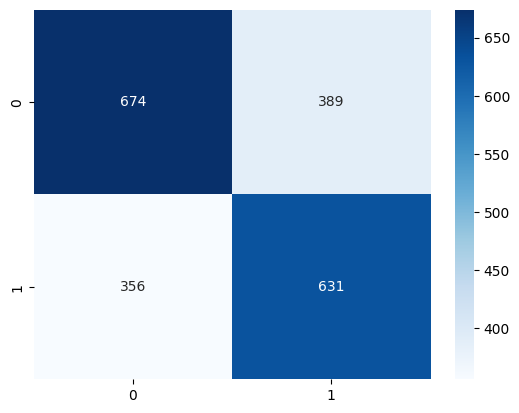

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 400)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **MLP 100*100 With a lot of data**

accrracy of Gaussian is 68.07
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      2055
           1       0.65      0.77      0.71      2045

    accuracy                           0.68      4100
   macro avg       0.69      0.68      0.68      4100
weighted avg       0.69      0.68      0.68      4100



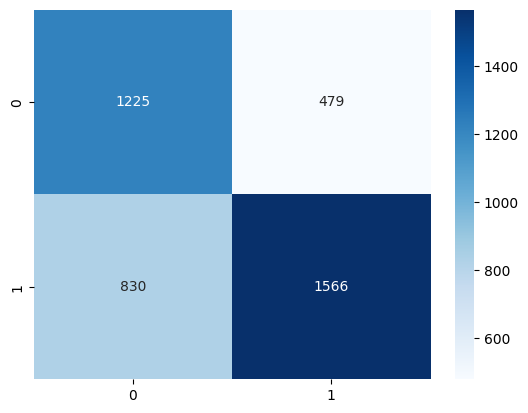

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **MLP with PCA 100*100 With a lot of data**

accrracy of Gaussian is 71.66
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2055
           1       0.71      0.73      0.72      2045

    accuracy                           0.72      4100
   macro avg       0.72      0.72      0.72      4100
weighted avg       0.72      0.72      0.72      4100



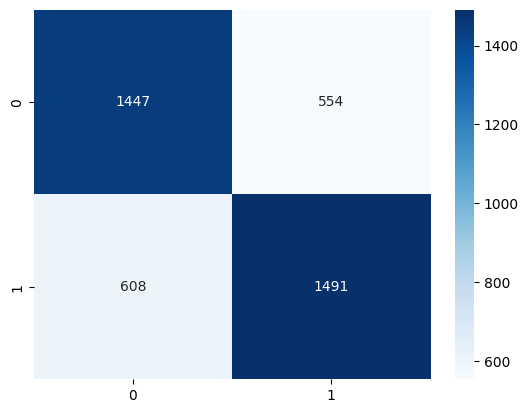

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

pca = PCA(n_components = 400)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **DecisionTree 128*128 data low**

accrracy of Gaussian is 62.10
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1030
           1       0.62      0.60      0.61      1020

    accuracy                           0.62      2050
   macro avg       0.62      0.62      0.62      2050
weighted avg       0.62      0.62      0.62      2050



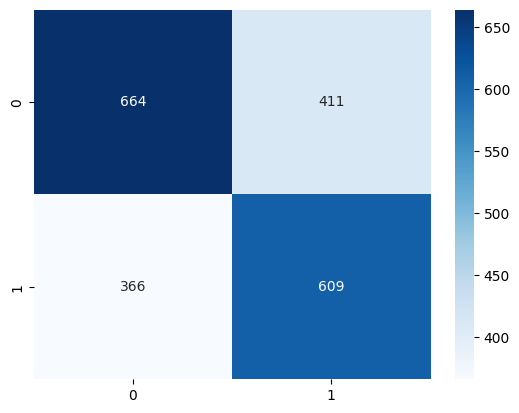

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

DT = DecisionTreeClassifier(max_depth=14).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


## **DecisionTree with PCA data low**

accrracy of Gaussian is 61.66
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1030
           1       0.61      0.63      0.62      1020

    accuracy                           0.62      2050
   macro avg       0.62      0.62      0.62      2050
weighted avg       0.62      0.62      0.62      2050



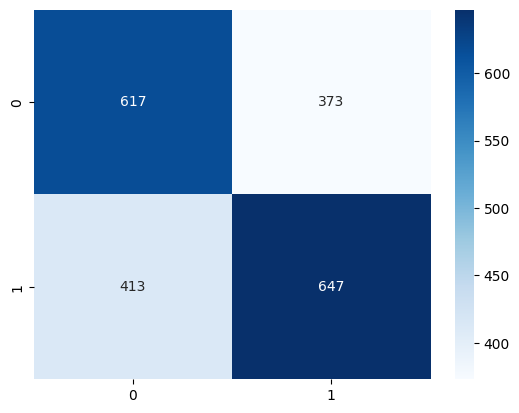

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


DT = DecisionTreeClassifier().fit(X_train, y_train)
#testpred = DT.predict(X_test)
#trainpred = DT.predict(X_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


## **DecisionTree 100*100 With a lot of data**

accrracy of Gaussian is 80.90
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2055
           1       0.80      0.82      0.81      2045

    accuracy                           0.81      4100
   macro avg       0.81      0.81      0.81      4100
weighted avg       0.81      0.81      0.81      4100



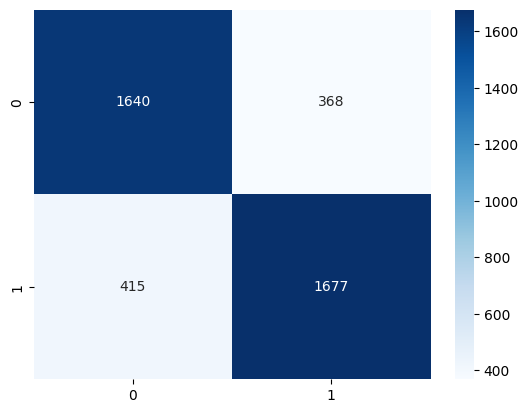

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DT = DecisionTreeClassifier(max_depth=14).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 85.15
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2055
           1       0.85      0.85      0.85      2045

    accuracy                           0.85      4100
   macro avg       0.85      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



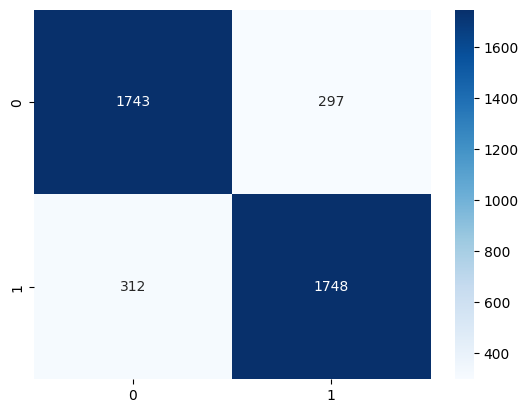

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

DT = DecisionTreeClassifier(max_depth=20).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 85.24
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2055
           1       0.85      0.86      0.85      2045

    accuracy                           0.85      4100
   macro avg       0.85      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



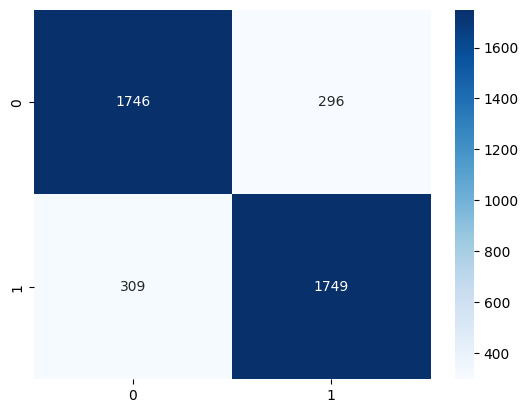

In [ ]:
DT = DecisionTreeClassifier(max_depth=25).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 84.44
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2055
           1       0.84      0.86      0.85      2045

    accuracy                           0.84      4100
   macro avg       0.84      0.84      0.84      4100
weighted avg       0.84      0.84      0.84      4100



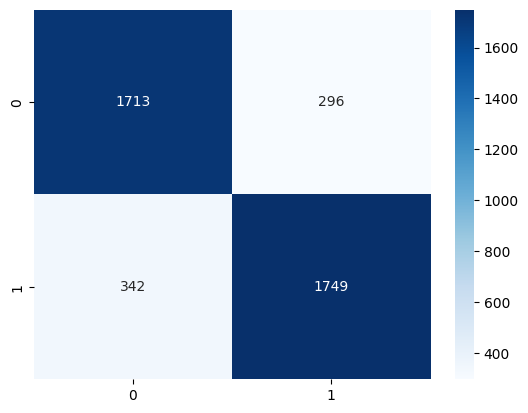

In [ ]:
DT = DecisionTreeClassifier(max_depth=22).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 84.61
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2055
           1       0.84      0.86      0.85      2045

    accuracy                           0.85      4100
   macro avg       0.85      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



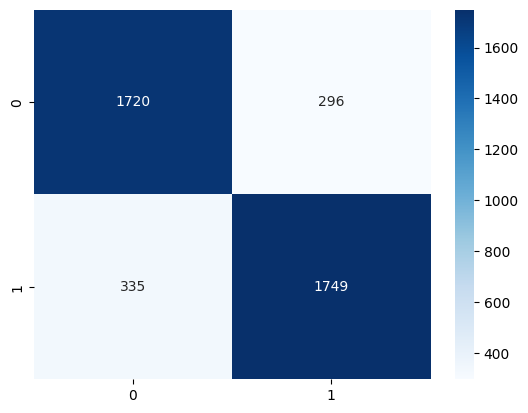

In [ ]:
DT = DecisionTreeClassifier(max_depth=18).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 85.17
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2055
           1       0.85      0.86      0.85      2045

    accuracy                           0.85      4100
   macro avg       0.85      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



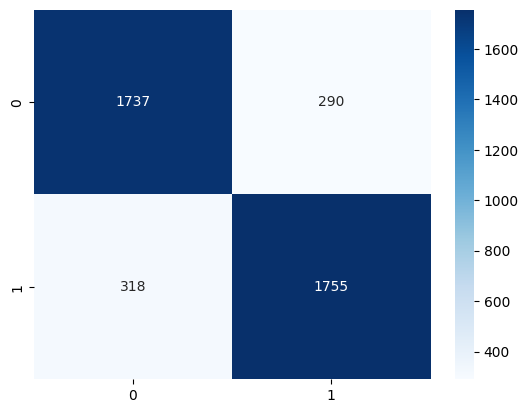

In [ ]:
DT = DecisionTreeClassifier(max_depth=30).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


accrracy of Gaussian is 85.02
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2055
           1       0.85      0.86      0.85      2045

    accuracy                           0.85      4100
   macro avg       0.85      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



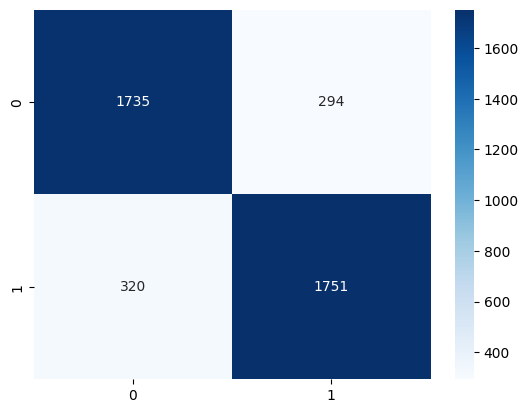

In [ ]:
DT = DecisionTreeClassifier(max_depth=35).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


## **DecisionTree 100*100 with PCA With a lot of data**

accrracy of Gaussian is 72.61
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      2055
           1       0.72      0.74      0.73      2045

    accuracy                           0.73      4100
   macro avg       0.73      0.73      0.73      4100
weighted avg       0.73      0.73      0.73      4100



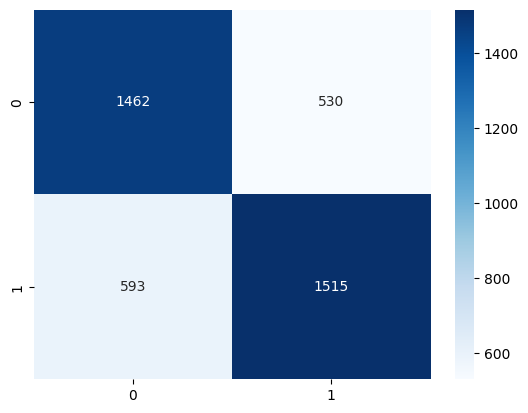

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features_of_images), np.array(labels), test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = 50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


DT = DecisionTreeClassifier().fit(X_train, y_train)
#testpred = DT.predict(X_test)
#trainpred = DT.predict(X_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


# *Classification models based on neural network features extraction*

## **Reading data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/Copy of features.csv')
df_label = pd.read_csv('/content/drive/MyDrive/ML/Copy of labels.csv')

## **Cleaning labels**

In [ ]:
df_labels = pd.DataFrame()

In [ ]:
from_source = ['real', 'fake']
from_class = {'real': 0, 'fake': 1}
def get_labels(path):
  #path = listToString(path)
  splited_path = (path.replace("-", "_").replace("sea5", "sea_5").lower().split("_"))

  if (len(splited_path) != 5):
    print(splited_path)
  image_class = splited_path[1]
  #print(image_class)
  if image_class not in from_class:
    print( image_class, path)

  return from_class[image_class]

In [ ]:
labels = list()
for filename in range(len(df_label)):
    if (df_label['810101213_fake_stable_mountain_2.png'][filename].endswith("jpeg") or df_label['810101213_fake_stable_mountain_2.png'][filename].endswith(".jpg")   or
        df_label['810101213_fake_stable_mountain_2.png'][filename].endswith(".png") or df_label['810101213_fake_stable_mountain_2.png'][filename].endswith(".jfif") or
        df_label['810101213_fake_stable_mountain_2.png'][filename].endswith(".webp")):

        try:
          labels.append(get_labels((df_label['810101213_fake_stable_mountain_2.png'][filename])))
        except Exception as e:
          print(e, filename)
    else:
      print(filename)
      print(df_label['810101213_fake_stable_mountain_2.png'][filename])

## **SVM**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

accrracy of SVM is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



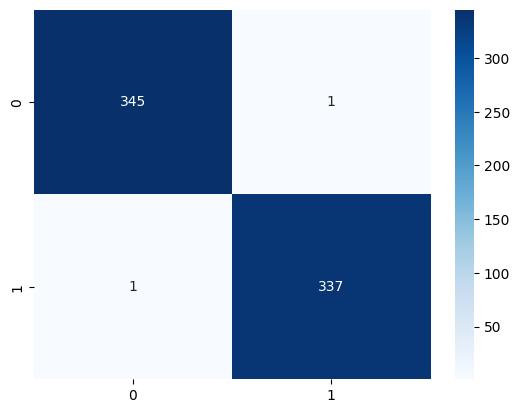

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **SVM with PCA**

accrracy of SVM is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



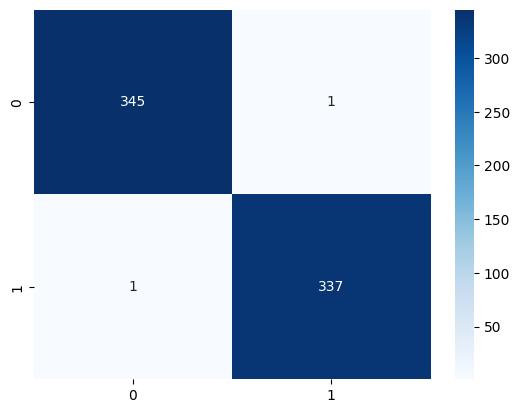

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_confusion_matrix = confusion_matrix(y_pred_svm,y_test)
sns.heatmap(svm_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

svm_accuracy = accuracy_score(y_pred_svm,y_test)*100
print('accrracy of SVM is {:.2f}'.format(svm_accuracy))
print(classification_report(y_test, svm.predict(X_test)))

## **LogisticRegression**

accrracy of logistic_regression is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



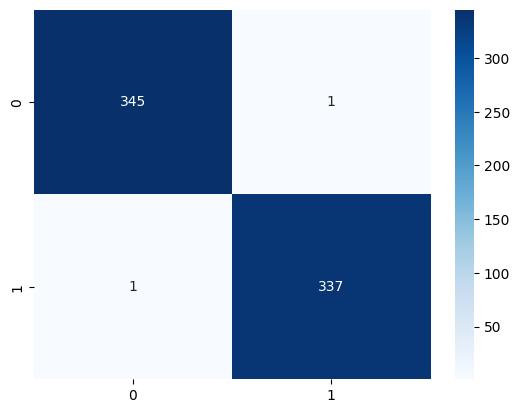

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **LogisticRegression with PCA**

accrracy of logistic_regression is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



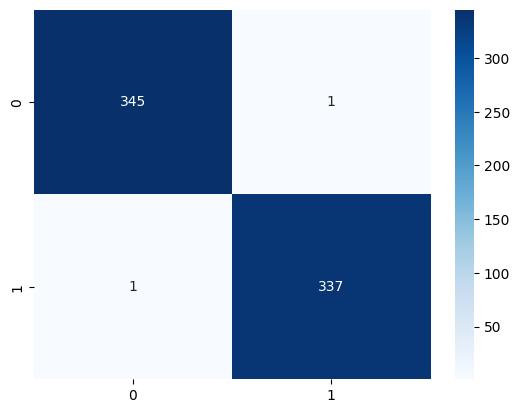

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 100)
X_train = pca.fit_transform(X_train)

X_test = pca.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

y_pred_logistic_regression = logistic_regression.predict(X_test)
logistic_regression_confusion_matrix = confusion_matrix(y_pred_logistic_regression,y_test)
sns.heatmap(logistic_regression_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

logistic_regression_accuracy = accuracy_score(y_pred_logistic_regression,y_test)*100
print('accrracy of logistic_regression is {:.2f}'.format(logistic_regression_accuracy))
print(classification_report(y_test, logistic_regression.predict(X_test)))

## **GaussianNB**

accrracy of Gaussian is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



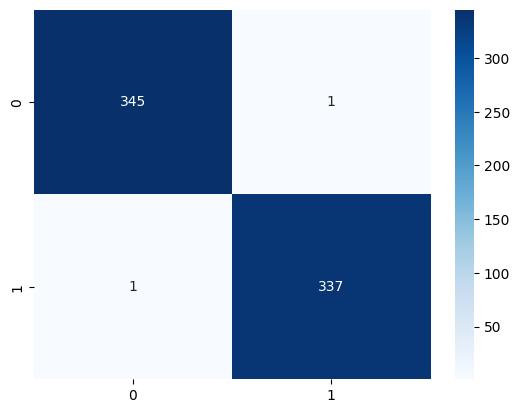

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **GaussianNB with PCA**

accrracy of Gaussian is 98.83
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       346
           1       0.98      1.00      0.99       338

    accuracy                           0.99       684
   macro avg       0.99      0.99      0.99       684
weighted avg       0.99      0.99      0.99       684



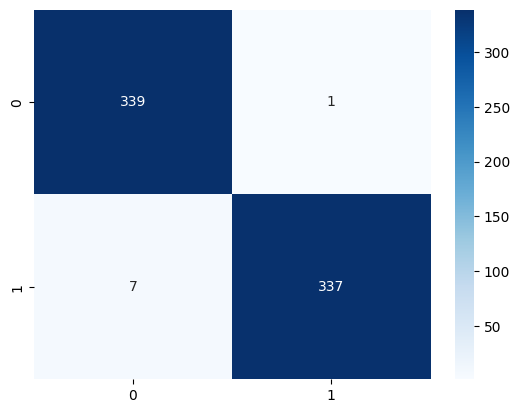

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred_gnb = gnb.predict(X_test)
gnb_confusion_matrix = confusion_matrix(y_pred_gnb,y_test)
sns.heatmap(gnb_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

gnb_accuracy = accuracy_score(y_pred_gnb,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(gnb_accuracy))
print(classification_report(y_test, gnb.predict(X_test)))

## **MLP**

accrracy of Gaussian is 99.56
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       346
           1       0.99      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



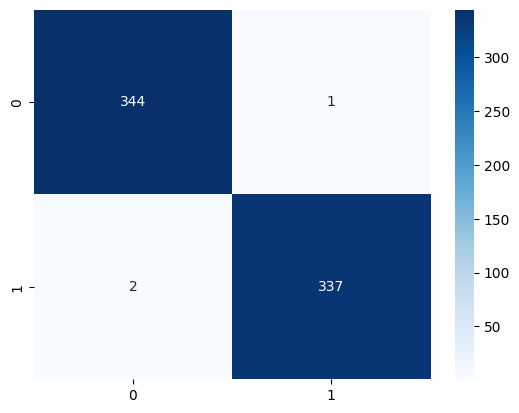

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **MLP with PCA**

accrracy of Gaussian is 99.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



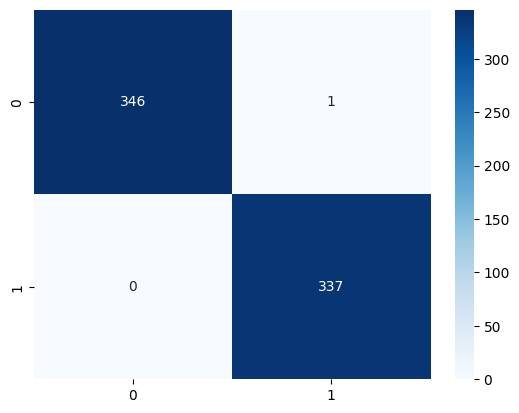

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 400)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

mlp = nn.MLPClassifier(hidden_layer_sizes=[128,32,32,16], alpha=3e-5, learning_rate='adaptive', early_stopping=True, shuffle=True, random_state=True).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
mlp_confusion_matrix = confusion_matrix(y_pred_mlp,y_test)
sns.heatmap(mlp_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

mlp_accuracy = accuracy_score(y_pred_mlp,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(mlp_accuracy))
print(classification_report(y_test, mlp.predict(X_test)))

## **DecisionTree**

accrracy of Gaussian is 99.71
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



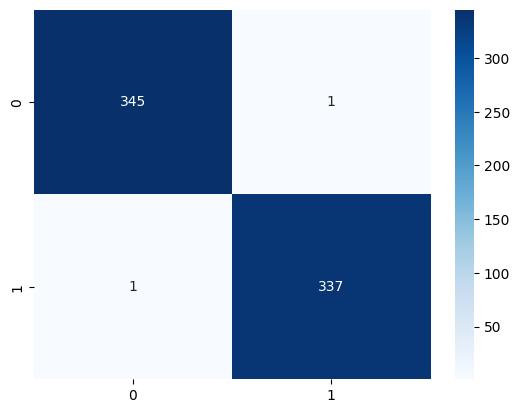

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)


DT = DecisionTreeClassifier(max_depth=14).fit(X_train, y_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))


## **DecisionTree with PCA**

accrracy of Gaussian is 99.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.00      1.00       338

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



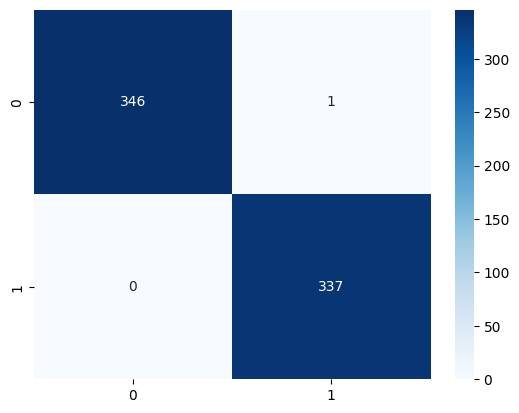

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


DT = DecisionTreeClassifier().fit(X_train, y_train)
#testpred = DT.predict(X_test)
#trainpred = DT.predict(X_train)

y_pred_DT = DT.predict(X_test)
DT_confusion_matrix = confusion_matrix(y_pred_DT,y_test)
sns.heatmap(DT_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

DT_accuracy = accuracy_score(y_pred_DT,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(DT_accuracy))
print(classification_report(y_test, DT.predict(X_test)))

In [ ]:
from sklearn.ensemble import VotingClassifier

X_train, X_test, y_train, y_test = train_test_split(np.array(df), np.array(labels), test_size=0.2, random_state=42)

pca = PCA(n_components = 500)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


SVM = SVC(kernel='linear',C=2, probability=True)
nb = GaussianNB()
ensemble = VotingClassifier(estimators=[('svm', SVM), ('nb', nb)], voting='soft')

ensemble.fit(X_train, y_train)



VotingClassifier(estimators=[('svm',
                              SVC(C=2, kernel='linear', probability=True)),
                             ('nb', GaussianNB())],
                 voting='soft')

accrracy of Gaussian is 94.44
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       346
           1       0.91      0.98      0.95       338

    accuracy                           0.94       684
   macro avg       0.95      0.94      0.94       684
weighted avg       0.95      0.94      0.94       684



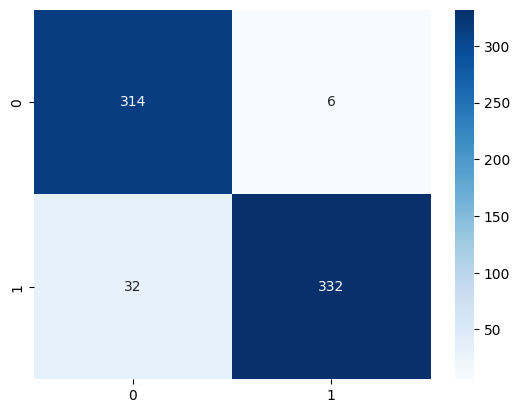

In [ ]:
y_pred_ensemble = ensemble.predict(X_test)
ensemble_confusion_matrix = confusion_matrix(y_pred_ensemble,y_test)
sns.heatmap(ensemble_confusion_matrix ,annot = True , fmt='.4g' , cmap='Blues')

ensemble_accuracy = accuracy_score(y_pred_ensemble,y_test)*100
print('accrracy of Gaussian is {:.2f}'.format(ensemble_accuracy))
print(classification_report(y_test, ensemble.predict(X_test)))